# 5/1/2024

In [18]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [178]:
# Resize 2D array of xy-data to a 1D column vector to be passed into CFD functions
def pack(u):
    Ny=u[:,1].size
    Nx=u[1,:].size
    uOut=np.zeros(Nx*Ny)
    for j in range(Ny):
        for i in range(Nx):
            uOut[Nx*j+i]=u[j,i]
    return uOut

# Resize 1D column vector returned from CFD functions to 2D array of xy-data for visualization
def unpack(vect,nx,ny):
    ntot=vect.size
    u=np.zeros([ny,nx])
    for j in range(ny):
        for i in range(nx):
            u[j,i]=vect[nx*j+i]
    return u

In [179]:
# 2D Nonlinear advection for every interior gridpoint in a 2D space, represented as a column vector with index mapping k = Nx * y + x
# To b used in Burge's Equation
def AdvectNonlin2DExpl(u, v, dx, dy, dt, Nx):
    u_next = np.zeros(u.size)
    v_next = np.zeros(v.size)
    for k in range(Nx, u.size - Nx):
        if u[k] > 0:
            if v[k] > 0:
                u_next[k] = (u[k] * (u[k] - u[k - 1]) / dx + v[k] * (u[k] - u[k - Nx]) / dy)
                v_next[k] = (u[k] * (v[k] - v[k - 1]) / dx + v[k] * (v[k] - v[k - Nx]) / dy)
            else:
                u_next[k] = (u[k] * (u[k] - u[k - 1]) / dx + v[k] * (u[k + 1] - u[k]) / dy)
                v_next[k] = (u[k] * (v[k] - v[k - 1]) / dx + v[k] * (v[k + 1] - v[k]) / dy)
        else:
            if v[k] > 0:
                u_next[k] = (u[k] * (u[k + 1] - u[k]) / dx + v[k] * (u[k] - u[k - Nx]) / dy)
                v_next[k] = (u[k] * (v[k + 1] - v[k]) / dx + v[k] * (v[k] - v[k - Nx]) / dy)
            else:
                u_next[k] = (u[k] * (u[k + 1] - u[k]) / dx + v[k] * (u[k + Nx] - u[k]) / dy)
                v_next[k] = (u[k] * (v[k + 1] - v[k]) / dx + v[k] * (v[k + Nx] - v[k]) / dy)
    return [u_next, v_next]

# 2D Diffusion for column vector k=Nx*y+x, to be used in Burger's Equation
def Diffuse2DExpl(u,v,dx,dy,dt,Nx,Re):
    u_next=np.zeros(u.size)
    v_next=np.zeros(v.size)
    for k in range(Nx,u.size-Nx):
        u_next[k]= (1/Re) * ((u[k+1]-2*u[k]+u[k-1])/(dx**2) + (u[k+Nx]-2*u[k]+u[k-Nx])/dy**2)
        v_next[k]= (1/Re) * ((v[k+1]-2*v[k]+v[k-1])/dx**2 + (v[k+Nx]-2*v[k]+v[k-Nx])/dy**2)
    return [u_next,v_next]

# 2D Burger's Equation, Advection + Diffusion
def Burgers2DExpl(u,v,dx,dy,dt,Nx,Re):
    u_next=np.zeros(u.size)
    v_next=np.zeros(v.size)
    [u_dif,v_dif]=Diffuse2DExpl(u,v,dx,dy,dt,Nx,Re)
    [u_adv,v_adv]=AdvectNonlin2DExpl(u,v,dx,dy,dt,Nx)
    u_next=u + dt*(u_dif-u_adv)
    v_next=v + dt*(v_dif-v_adv)
    return [u_next,v_next]

# Pressure Solver2 with Nuemann BCs on all boundaries (dP/dn = 0), pressure at center of mesh is 0
def pressureSolver2(u,v,dx,dy,Nx,Ny):
    A=np.zeros([u.size,u.size])
    b=np.zeros(u.size)
    center_index=int(Nx*(Ny/2)+Nx/2)
    for k in range(u.size):
        if k == center_index:  # Set the pressure at the center to zero
            A[k, k] = 1
            b[k] = 0
        elif k % Nx == 0:  # Left boundary
            A[k, k] = 1
            A[k, k + 1] = -1  # Enforcing P[k] = P[k+1]
        elif (k + 1) % Nx == 0:  # Right boundary
            A[k, k] = 1
            A[k, k - 1] = -1  # Enforcing P[k] = P[k-1]
        elif k < Nx:  # Bottom boundary
            A[k, k] = 1
            A[k, k + Nx] = -1  # Enforcing P[k] = P[k+Nx]
        elif k >= Nx * (Ny - 1):  # Top boundary
            A[k, k] = 1
            A[k, k - Nx] = -1  # Enforcing P[k] = P[k-Nx]
        else: #center of mesh
            A[k,k-Nx]=1/dy**2
            A[k,k-1]=1/dx**2
            A[k,k]=-2/dx**2-2/dy**2
            A[k,k+1]=1/dx**2
            A[k,k+Nx]=1/dy**2
            b[k]=(2/dt) * ((u[k+1]-u[k-1])/(2*dx) + (v[k+Nx]-v[k-Nx])/(2*dy))
    return np.linalg.solve(A,b)

# Projection Method for pressure equation
# Solve Burgers for half timestep, solve for pressure with pressureSolver, update velocity field using V(n+1)=V(*)-1/2dt \delP, enforce div(V)=0
def ProjectionMethod(u,v,dx,dy,dt,Nx,Ny,Re):
    u_next=np.zeros(u.size)
    v_next=np.zeros(v.size)
    dth=0.5*dt
    [ustar,vstar]=Burgers2DExpl(u,v,dx,dy,dth,Nx,Re)
    P=pressureSolver2(ustar,vstar,dx,dy,Nx,Ny)
    for k in range(Nx,u.size-Nx):
        u_next[k]=ustar[k]-0.5*dt*((P[k+1]-P[k-1])/(2*dx))
        v_next[k]=vstar[k]-0.5*dt*((P[k+Nx]-P[k-Nx])/(2*dy))
    return [u_next,v_next,P]
        

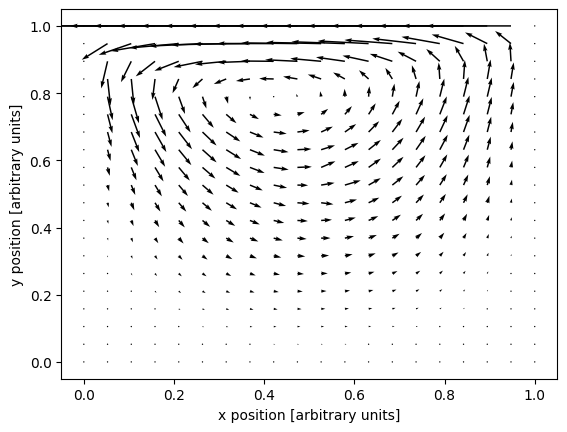

In [188]:
# Lid-driven Cavity

T=3
dx=0.05
dy=dx
dt=0.005
Lx = 1
Ly = 1
Nx = int(Lx/dx)
Ny = int(Ly/dy)
Ntot = Nx*Ny
Nt = int(T/dt)

x2=np.linspace(0,Lx,Nx)
y2=np.linspace(0,Ly,Ny)

# set initial conditions, zero velocity
u1=np.zeros([Nx,Ny])
v1=np.zeros([Nx,Ny])

ustack=pack(u1)
vstack=pack(v1)

Re=50


usol4=np.copy(ustack)
vsol4=np.copy(vstack)
uNext=np.zeros_like(ustack)
vNext=np.zeros_like(vstack)
ssconx=np.zeros(Nt)
sscony=np.zeros(Nt)
for i in range(Nt):
    [uNext,vNext,P]=ProjectionMethod(usol4,vsol4,dx,dy,dt,Nx,Ny,Re)
    # BCs
    uNext[0:Nx]=0 #Bottom boundary condition
    vNext[0:Nx]=0
    uNext[Nx*(Ny-1):Nx*Ny]=-1 #Top boundary condition
    vNext[Nx*(Ny-1):Nx*Ny]=0
    for k in range(0,Nx*Ny):
        if k%Nx==0: #Left boundary condition
            uNext[k]=0
            vNext[k]=0
        if (k+1)%Nx==0: #Right boundary condition
            uNext[k]=0
            vNext[k]=0
    
    ssconx[i]=np.linalg.norm(uNext-usol4)
    sscony[i]=np.linalg.norm(vNext-vsol4)
    usol4=np.copy(uNext)
    vsol4=np.copy(vNext)
            
    
usol4xy=unpack(usol4,Nx,Ny)
vsol4xy=unpack(vsol4,Nx,Ny)

x2p,y2p=np.meshgrid(x2,y2)
plt.quiver(x2p,y2p,usol4xy,vsol4xy)
plt.xlabel('x position [arbitrary units]')
plt.ylabel('y position [arbitrary units]')
plt.show()


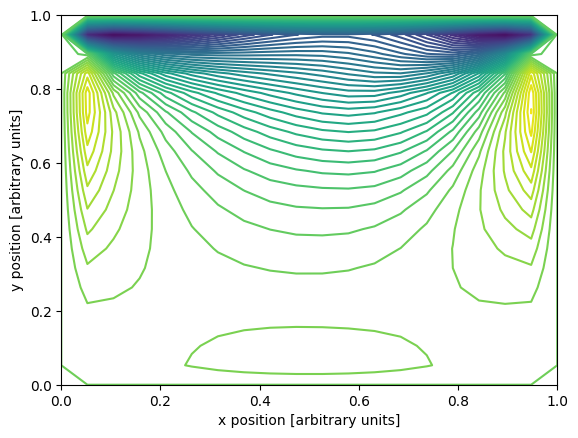

In [119]:
# Extract Vorticity curl(V)=dv/dx - du/dy
vort=np.zeros(Nx*Ny)
vort2=np.zeros([Nx,Ny])
for k in range(Nx,(Nx-1)*Ny):
    vort[k]=(vsol4[k+1]-vsol4[k-1])/(2*dx) - (usol4[k+Nx]-usol4[k-Nx])/(2*dy)

for i in range(1,Nx-1):
    for j in range(1,Ny-1):
        vort2[j,i]=-(usol4xy[j+1,i]-usol4xy[j-1,i])/(2*dy) + (vsol4xy[j,i+1]-vsol4xy[j,i-1])/(2*dx)

vortxy=unpack(vort,Nx,Ny)
plt.contour(x2p,y2p,vort2,levels=50)
plt.xlabel('x position [arbitrary units]')
plt.ylabel('y position [arbitrary units]')
plt.show()